In [1]:
from mylib.statistic_test import *

code_id = "0873 - Decision Points and Behavior"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0873 - Decision Points and Behavior is already existed!


False

[  2  86 110 135  53  52   7  44  24  78 105  82  70  60  95 119 144]
For Duration:
Maze A: TtestResult(statistic=-2.8949281483027356, pvalue=0.03399095960907545, df=5)
Maze B: TtestResult(statistic=-6.69974852554786, pvalue=0.0011208789035592295, df=5)


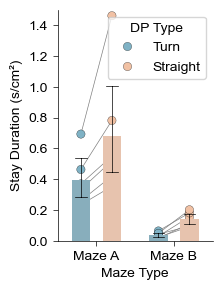

For Frequency:
Maze A: TtestResult(statistic=-3.2534419051144416, pvalue=0.022609409209234262, df=5)
Maze B: TtestResult(statistic=-6.337336278999094, pvalue=0.0014433425651605943, df=5)


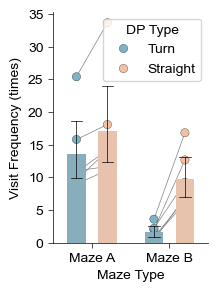

In [49]:
DP2 = DPs[2]
print(DP2)
# 0: Left, 1: Right, 2: Straight
Label1 = np.array([2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 2, 2])
Label2 = np.array([2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0])

BinNum1 = np.array([1, 1, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 2, 4, 3, 1, 5])
BinNum2 = np.array([4, 1, 1, 8, 2, 7, 2, 1, 3, 1, 6, 1, 1, 1, 1, 1, 1]) 

def get_occupation_time(trace):
    maze_type = int(trace['maze_type'])
    
    G = DP2WG[maze_type]

    occu_time = np.zeros(DPs[maze_type].shape[0])
    for i in range(DPs[maze_type].shape[0]):
        dp = DPs[maze_type][i]
        sonbins = np.concatenate([
            Father2SonGraph[i] for i in G[dp]
        ])
        dt = np.diff(trace['correct_time'])
        idx = np.where(np.isin(trace['correct_nodes'][:-1], sonbins))[0]
        if len(idx) == 0:
            continue
        occu_time[i] = np.nansum(dt[idx]) / len(G[dp])
    
    return occu_time/1000
    
def get_visit_times(trace):
    maze_type = int(trace['maze_type'])
    
    G = DP2WG[maze_type]
    
    visit_times = np.zeros(DPs[maze_type].shape[0])
    for i in range(DPs[maze_type].shape[0]):
        dp = DPs[maze_type][i]
        sonbins = np.concatenate([
            Father2SonGraph[i] for i in G[dp]
        ])
        is_in_path = np.where(np.isin(trace['correct_nodes'], sonbins), 1, 0)
        dvisit = np.diff(is_in_path)
        visit_idx = np.where(dvisit == 1)[0]
        leave_idx = np.where(dvisit == -1)[0]
        assert visit_idx.shape[0] == leave_idx.shape[0] 
        
        if visit_idx.shape[0] == 0:
            continue
        
        stay_dur = (trace['correct_time'][leave_idx] - trace['correct_time'][visit_idx])/1000
        leave_interval = np.append([np.inf], (trace['correct_time'][visit_idx[1:]] - trace['correct_time'][leave_idx[:-1]])/1000)
        
        valid_idx = np.where(
            (stay_dur >= 0.5) &
            (leave_interval >= 1)
        )[0]
        
        visit_times[i] = valid_idx.shape[0]
    
    return visit_times

if exists(join(figdata, f"{code_id} [Visit Duration and Frequency].pkl")) == False:
    FST = {
        "MiceID": [],
        "DP Type": [],
        "Maze Type": [],
        "Duration": [],
        "Frequency": [],
        "Bin ID" : []
    }

    for mouse in tqdm([10209, 10212, 10224, 10227, 10232, 10234]):
        idx0 = np.where(
            (f1['MiceID'] == mouse) &
            (f1['Stage'] == 'Stage 1') &
            (f1['maze_type'] == 1) &
            (f1['training_day'] == 'Day 1')
        )[0]
        idx1 = np.where(
            (f1['MiceID'] == mouse) &
            (f1['Stage'] == 'Stage 2') &
            (f1['maze_type'] == 2) &
            (f1['training_day'] == 'Day 1')
        )[0]
        
        for idx in [idx0, idx1]:
            if idx.shape[0] == 0:
                continue
            with open(f1['Trace File'][idx[0]], 'rb') as f:
                trace = pickle.load(f)
                
            maze_type = int(trace['maze_type'])

            occu_time = get_occupation_time(trace)
            visit_times = get_visit_times(trace)

            maze = 'Maze A' if maze_type == 1 else 'Maze B'
            labels = Label1 if maze_type == 1 else Label2
            DP = DPs[maze_type]

            FST['MiceID'].append(np.repeat(mouse, occu_time.shape[0]))
            FST['DP Type'].append(labels)
            FST['Maze Type'].append(np.repeat(maze, occu_time.shape[0]))
            FST['Duration'].append(occu_time)
            FST['Frequency'].append(visit_times)
            FST['Bin ID'].append(np.arange(DP.shape[0]))

    for k in FST.keys():
        FST[k] = np.concatenate(FST[k])

    with open(join(figdata, f"{code_id} [Visit Duration and Frequency].pkl"), 'wb') as f:
        pickle.dump(FST, f)

    FST_D = pd.DataFrame(FST)
    FST_D.to_excel(join(figdata, f"{code_id} [Visit Duration and Frequency].xlsx"), index=False)
    print(len(FST_D))
else:
    with open(join(figdata, f"{code_id} [Visit Duration and Frequency].pkl"), 'rb') as f:
        FST = pickle.load(f)

if exists(join(figdata, f"{code_id} [Maze Average].pkl")) == False:
    AvgFST = {
        "MiceID": [],
        "DP Type": [],
        "Maze Type": [],
        "Duration": [],
        "Frequency": []
    }
    
    for maze in ['Maze A', 'Maze B']:
        for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
                idx0 = np.where(
                    (FST['Maze Type'] == maze) &
                    (FST['MiceID'] == mouse) &
                    (FST['DP Type'] <= 1)
                )[0]
                idx2 = np.where(
                    (FST['Maze Type'] == maze) &
                    (FST['MiceID'] == mouse) &
                    (FST['DP Type'] == 2)
                )[0]
                print(idx0.shape, idx2.shape)
                if idx0.shape[0] == 0 or idx2.shape[0] == 0:
                    print(mouse, maze)
                    continue

                for idx in [idx0, idx2]:
                    dp_type = "Straight" if FST['DP Type'][idx[0]] == 2 else "Turn"
                    AvgFST['DP Type'].append(dp_type)
                    AvgFST['Maze Type'].append(maze)
                    AvgFST['Duration'].append(np.nanmean(FST['Duration'][idx]))
                    AvgFST['Frequency'].append(np.nanmean(FST['Frequency'][idx]))
                    AvgFST['MiceID'].append(mouse)

    for k in AvgFST.keys():
        AvgFST[k] = np.array(AvgFST[k])

    with open(join(figdata, f"{code_id} [Maze Average].pkl"), 'wb') as f:
        pickle.dump(AvgFST, f)

    AvgFST_D = pd.DataFrame(AvgFST)
    AvgFST_D.to_excel(join(figdata, f"{code_id} [Maze Average].xlsx"), index=False)
    print(len(AvgFST_D))
else:
    with open(join(figdata, f"{code_id} [Maze Average].pkl"), 'rb') as f:
        AvgFST = pickle.load(f)
AvgFST['Duration'] /= 64 # convert to seconds per cm^2

for key_name in ['Duration', 'Frequency']:
    fig = plt.figure(figsize=(2,3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.stripplot(
        x='Maze Type', 
        y=key_name, 
        hue='DP Type', 
        data=pd.DataFrame(AvgFST), 
        palette = ['#7fb2c5', '#f1c1a4'], 
        size=6,
        dodge=True,
        jitter=0,
        linewidth=0.2,
        edgecolor='black',
        ax=ax,
        zorder=1
    )
    print(f"For {key_name}:")
    for j, maze in enumerate(['Maze A', 'Maze B']):
        turn = AvgFST[key_name][
            (AvgFST['Maze Type'] == maze) &
            (AvgFST['DP Type'] == 'Turn')
        ]
        straight = AvgFST[key_name][
            (AvgFST['Maze Type'] == maze) &
            (AvgFST['DP Type'] == 'Straight')
        ]
        print(f"{maze}: {ttest_rel(turn, straight)}")
        for i in range(turn.shape[0]):
            ax.plot(
                [j - 0.2, j + 0.2], 
                [turn[i], straight[i]], 
                color='gray', 
                linewidth=0.5, 
                zorder=0
            )
    sns.barplot(
        x='Maze Type', 
        y=key_name, 
        hue='DP Type', 
        data=pd.DataFrame(AvgFST), 
        palette = ['#7fb2c5', '#f1c1a4'], 
        err_kws={'color': 'k', 'linewidth':0.5},
        capsize=0.3,
        ax=ax,
        gap=0.4,
        legend=False
    )
    if key_name == 'Frequency':
        ax.set_ylabel("Visit Frequency (times)")
    else:
        ax.set_ylabel("Stay Duration (s/cm²)")
        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(0, 1.5)
    plt.savefig(join(loc, "Stay Duration.svg"), dpi=600)
    plt.savefig(join(loc, "Stay Duration.png"), dpi=600)
    plt.show()